In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std, median
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,  train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, recall_score,r2_score, accuracy_score, cohen_kappa_score, classification_report, confusion_matrix, precision_score,f1_score 
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, StratifiedKFold 
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline as imbpipeline
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
#Random seed used in R was 7
random_seed=7

In [3]:
#read input data
#data=pd.read_csv('EX2_Input_MV.csv') #all 986 synsets
data=pd.read_csv('EX2_Input_AllAgreed.csv') #839 synsets where all annotators agree

In [4]:
test_data=pd.read_csv('GS_not_agreed_synsets.csv') #synsets where annotators do not agree to test 

In [5]:
d_tools=pd.DataFrame(data.loc[data['Domain']=='tool'])
d_fruit=pd.DataFrame(data.loc[data['Domain']=='fruit'])
d_music=pd.DataFrame(data.loc[data['Domain']=='music'])
d_furn=pd.DataFrame(data.loc[data['Domain']=='furn'])
d_garm=pd.DataFrame(data.loc[data['Domain']=='garm'])

In [6]:
#set features and target variable
#use best performing features from each corpora 
# 'ngrams_last_mean', 'CHILDES_Sum_Rel','KBNC_Sum','CABNC_per100,000', 'nrdirhypers_x','BNC_sum'
features=[
 'nrdirhypers',
 'nrhypos',
 'nrpartrels_normalised',
 'depthfromtopsynset_normalised',
 'glosslength_normalised',
 'minwordlength',
 'nroflemmas',
 'polyscore_max',
 'BNC_sum']
target=['vote']

In [7]:
#train on 2 domains test on one unseen to see performance across new domains
music=[d_tools, d_fruit] #train on tools and fruit, test on music
fruit=[d_tools, d_music]
tools=[d_fruit, d_music]
m=pd.concat(music)
f=pd.concat(fruit)
t=pd.concat(tools)

In [8]:
#train on 4 domains test on one unseen 
garments=[d_furn, d_fruit, d_music, d_tools] 
furniture=[d_fruit, d_music, d_tools, d_garm]
fru=[d_furn, d_music, d_tools, d_garm]
mus=[d_furn, d_fruit, d_tools, d_garm]
too=[d_furn, d_fruit, d_music, d_garm]
g=pd.concat(garments) #train on furn, fruit, music and tools and test on garments
furn=pd.concat(furniture)
fr=pd.concat(fru)
mu=pd.concat(mus)
to=pd.concat(too)

In [9]:
#manual splits to simulate how generalisable model is 
X_train=np.array(to[features]) #concated df name (g, furn, fr, mu, to) of unseen domain
X_test=np.array(d_tools[features]) #d_domain (d_garm, d_furn, d_fruit..) of unseen domain
y_train=np.array(to[target])
y_test=np.array(d_tools[target])

In [10]:
#run SMOTE algorithm to deal with class imbalances - make basic class same amount as non-basic
sm = SMOTE(random_state=random_seed, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)
print ('Shape of oversampled data: {}'.format(X_train.shape))
print ('Shape of Y: {}'.format(y_train.shape))

Shape of oversampled data: (1112, 9)
Shape of Y: (1112,)


In [11]:
#define model and fit oversampled training sets
rf = RandomForestClassifier(random_state=random_seed, max_features="sqrt", n_estimators=500, oob_score=True, criterion='gini', bootstrap=True).fit(X_train, y_train.ravel())

In [12]:
kappa_scorer=make_scorer(cohen_kappa_score) #to generate kappa scores in CV

In [13]:
#pipeline for CV to first run smote prior to fitting RF in each loop - ensures no data leakage
pipeline=imbpipeline(sm, rf)

In [14]:
#predict test set from training split
y_pred = pipeline.predict(X_test)
cr=(classification_report(y_test,y_pred, output_dict=True))
report=pd.DataFrame(cr).transpose()
report
cr=(classification_report(y_test,y_pred, output_dict=True))
ck=(cohen_kappa_score(y_test, y_pred))
ba=(balanced_accuracy_score(y_test, y_pred))
report=pd.DataFrame(cr).transpose()
report['Cohen Kappa']=ck
report['Balanced Accuracy']=ba

In [15]:
report['Trained on']='fruit, music, furniture and garments'
report['Tested on']='tools'

In [16]:
report

,precision,recall,f1-score,support,Cohen Kappa,Balanced Accuracy,Trained on,Tested on
b,0.909091,0.800000,0.851064,25.000000,0.819258,0.890741,"fruit, music, furniture and garments",tools
nb,0.954955,0.981481,0.968037,108.000000,0.819258,0.890741,"fruit, music, furniture and garments",tools
accuracy,0.947368,0.947368,0.947368,0.947368,0.819258,0.890741,"fruit, music, furniture and garments",tools
macro avg,0.932023,0.890741,0.909550,133.000000,0.819258,0.890741,"fruit, music, furniture and garments",tools
weighted avg,0.946334,0.947368,0.946049,133.000000,0.819258,0.890741,"fruit, music, furniture and garments",tools


Feature: 0, Score: 0.00468
Feature: 1, Score: 0.07687
Feature: 2, Score: 0.13716
Feature: 3, Score: 0.29896
Feature: 4, Score: 0.11131
Feature: 5, Score: 0.08829
Feature: 6, Score: 0.05293
Feature: 7, Score: 0.07477
Feature: 8, Score: 0.15503


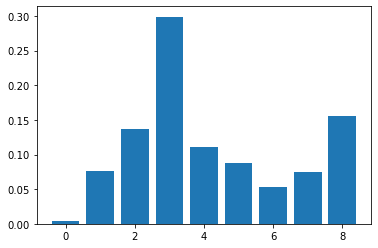

In [17]:
# get feature importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig1=plt.figure()
a=plt.bar([x for x in range(len(importance))], importance)
#plt.savefig('ck/feature_importance_global.png')
plt.show()

In [18]:
imp=[]
for i,v in enumerate(importance):
    imp.append(v)

In [19]:
df4=pd.DataFrame(imp)
df4['Features']=features
df4=df4.rename(columns={0:'Importance'})

In [20]:
df5=df4[['Features', 'Importance']].sort_values('Importance',ascending=False)

In [21]:
df5=df5.rename(columns={'index':'Rank'})

In [22]:
df5

,Features,Importance
3,depthfromtopsynset_normalised,0.298961
8,BNC_sum,0.155028
2,nrpartrels_normalised,0.137161
4,glosslength_normalised,0.111312
5,minwordlength,0.088294
1,nrhypos,0.076868
7,polyscore_max,0.074766
6,nroflemmas,0.052932
0,nrdirhypers,0.004678


In [23]:
#report.to_csv('results/features/unseen/CR_bnc_unseen_tools.csv')

In [24]:
#df5.to_csv('results/features/unseen/FI_bnc_unseen_tools.csv')